# Tutorial 6 - Deep Learning

**Course:** SYS 4415 - Introduuction to Machine Learning

**Semester:** Fall 2021

**Adapted by:** [Kevin Dick](https://kevindick.ai/)

**Adapted from:** [Keras v. TensorFlow Tutorial](https://www.pyimagesearch.com/2018/10/08/keras-vs-tensorflow-which-one-is-better-and-which-one-should-i-learn/) and [LSTM Neural Network to Predict the Stock Market](https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction)

---

In this two-part notebook, we will demonstrate the creation of a Convolutional Neural Network classifier (part I) and a Long-Short Term Memory (LSTM) Recurrent Neuural Network classifier (part II):

**Part 0: Introduction to the Keras API**

**Part I: CNN for CIFAR-10 Classification**
1. load a benchmark computer vision dataset (CIFAR-10)
2. create a VGGNet-like architecture
3. train, evaluate, and test the model on the CIFAR-10 benchmark
**Part II: LSTM for Stock Market Prediction** 
1. load historical stock data for a given ticker symbol
2. normalize stock data within a given window
3. create an LSTM model and fit it to training data
4. generate and plot predictions over future

---
# Part 0: Introduction to the Keras API

## Keras: The Python Deep Learning API

Keras is the **high-level API of TensorFlow 2.0**, meant to be an approchable and highly-productive interface for solving machine learning problems, with a focus on modern deep learning. It **provides essential abstractions** and building blocks for developing and shipping machine learning solutions with high iteration velocity.

## The Convolutional Neural Network (CNN)

In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, **most commonly applied to analyzing visual imagery**. They are also known as **shift invariant** or **space invariant artificial neural networks**, based on their shared-weights architecture and translation invariance characteristics.

In this tutorial, we will implement a VGG-type CNN based on the work of the **V**isual **G**eometry **G**roup at the University of Oxford. Several pre-trained model architectures and learned weights are easily downloadable from the Keras library, such as the **VGG-16 model**.

**Additional Reading**: [10 Illustrated CNN Architectures](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d)

---

When first learning to create deep learning models, it is important to understand the role of each type of layer; familiairization of the **[Keras API documentation](https://keras.io/api/layers/))** is one of the best approaches!

For convenience, three of the **[Core Layers](https://keras.io/api/layers/core_layers/)** covered in part I of this tutorial are replicated here:

### Keras Layers: **[Input Object](https://keras.io/api/layers/core_layers/input/)**

```python
tf.keras.Input(
    shape=None,     # A shape tuple (integers), not including the batch size. For instance, shape=(32,) indicates that the expected input will be batches of 32-dimensional vectors.
    batch_size=None,# optional static batch size (integer).
    name=None,      # An optional name string for the layer. Should be unique in a model (do not reuse the same name twice).
    dtype=None,     # The data type expected by the input, as a string (float32, float64, int32...)
    sparse=False,   # A boolean specifying whether the placeholder to be created is sparse. 
    tensor=None,    # Optional existing tensor to wrap into the Input layer. 
    ragged=False,   # A boolean specifying whether the placeholder to be created is ragged.
    **kwargs
)
```

### Keras Layers: **[Dense Layer](https://keras.io/api/layers/core_layers/dense/)**


```python
tf.keras.layers.Dense(
    units,                              # Positive integer, dimensionality of the output space.
    activation=None,                    # Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).
    use_bias=True,                      # Boolean, whether the layer uses a bias vector.
    kernel_initializer="glorot_uniform",# Initializer for the kernel weights matrix.
    bias_initializer="zeros",           # Initializer for the bias vector.
    kernel_regularizer=None,            # Regularizer function applied to the kernel weights matrix. 
    bias_regularizer=None,              # Regularizer function applied to the bias vector.
    activity_regularizer=None,          # Regularizer function applied to the output of the layer (its "activation").
    kernel_constraint=None,             # Constraint function applied to the kernel weights matrix.
    bias_constraint=None,               # Constraint function applied to the bias vector.
    **kwargs
)
```

### Keras Layers: **[Activation Layer](https://keras.io/api/layers/core_layers/activation/)**
```python
tf.keras.layers.Activation(
  activation, # Activation function, such as tf.nn.relu, or string name of built-in activation function, such as "relu"
  **kwargs
)
```

---

# Part I: Building a VGG16 CNN Classifer for the the CIFAR-10 Dataset

- VGG16 developed by the VGG (Visual Geometry Group, University of Oxford) for the ILSVRC-2014 competition. 
- Published at: [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)
- Note that VGG16 is available (pre-trained) through Keras.applications

```python
        from keras.applications import VGG16
        VGG16.summary() # Print a summary of the network structure
```
    
- VGGNet-like architectures are characterized by: 
    1. Using only 3×3 convolutional layers stacked on top of each other in increasing depth
    2. Reducing volume size by max pooling
    3. Fully-connected layers at the end of the network prior to a softmax classifier


### The CIFAR-10 Dataset

**Fun Fact:** CIFAR = "Canadian Institute For Advanced Research"

A **benchmark dataset** is a reference database against which learning models are evaluated and performance assessed to determine whether or not a given approach is superior over another.

The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

The classes are: ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

![CIFAR-10](https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/datasets/cifar10.png)

The dataset is divided into **five training batches and one test batch**, each with 10,000 images. The **test batch contains exactly 1,000 randomly-selected images from each class**. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5,000 images from each class.

Published at: https://www.cs.toronto.edu/~kriz/cifar.html

---

### Hardware Acceleration: Enabling the Collab GPU

To accelerate the training-phase and inference-phase of deep learning models, Google collab provides GPUs which greatly accellerates model development.

For example, using CPU alone, each epoch of the CNN would require ~450 seconds whereas with GPU each only requires ~7s.

To verify whether GPUs are enabled:  `Runtime` $\rightarrow$ `Change runtime type` $\rightarrow$ `Hardware accelerator`

In [1]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import LabelBinarizer # For 1-hot encoding of 10 class labels
from keras.datasets import cifar10  						 # Built-in dataset of images.
from sklearn.metrics import classification_report

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Define the "MiniVGGnetKeras" Class 

The "MiniVGGNetKeras" class that will build the VGG deep net when `.build()` is invoked upon an instance of this class object.

In [2]:
# Define a class to represent the VGG-type network. Instantiate using build()
class MiniVGGNetKeras:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the input shape and channel dimension, assuming
		# TensorFlow/channels-last ordering
		inputShape = (height, width, depth)
		chanDim = -1
 
		# define the model input (layer)
		inputs = Input(shape=inputShape)
  
  	# first (CONV => RELU) * 2 => POOL layer set
		x = Conv2D(32, (3, 3), padding="same")(inputs) # padding=same --> output same size as input by padding by filter/2 rows/cols of zeros
		x = Activation("relu")(x) 										 # Add a rectified linear unit activation function to each conv layer
		x = BatchNormalization(axis=chanDim)(x)  			 # Use batch normalization. We will talk about this later
		x = Conv2D(32, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x) 					# MaxPooling uased after the first 2 conv layers. Reduces size of subsequent layers by down-sampling
		x = Dropout(0.25)(x)  													# Dropout used to promote generalization. We'll talk about this layer type later in the course...
 
		# second (CONV => RELU) * 2 => POOL layer set
		x = Conv2D(64, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Conv2D(64, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)
  
    # first (and only) set of FC => RELU layers
		x = Flatten()(x)  # Flatten the 2D maxPooling2D layer to feed into a fully-connected layer
		x = Dense(512)(x)
		x = Activation("relu")(x)
		x = BatchNormalization()(x)
		x = Dropout(0.5)(x)
 
		# Softmax classifier layer for arriving at normalized prediction scores for multi-class problem. 
    # Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0.
    # Only makes sense when each image is expected to represent a single class (not a dog & a cat simultaneously)
		x = Dense(classes)(x)
		x = Activation("softmax")(x)
 
		# create the model and give it a unique name
		model = Model(inputs, x, name="minivggnet_keras")
 
		# return the constructed network architecture
		return model

# Download and prepare the CIFAR-10 dataset

In [3]:
# load the training and testing data, then scale it into the range [0, 1]
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX  = testX.astype("float") / 255.0
 
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
 
# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer",
	"dog", "frog", "horse", "ship", "truck"]


[INFO] loading CIFAR-10 data...


# Build and train a VGG16 model using the CIFAR-10 dataset

In [4]:
# initialize the initial learning rate, total number of epochs to
# train for, and batch size
INIT_LR = 0.01
EPOCHS = 30 # Each epoch takes 450s using CPU and only ~30s using GPU (Runtime->Change runtime->EnableGPU)
BS = 32
 
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = MiniVGGNetKeras.build(width=32, height=32, depth=3, classes=len(labelNames))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Visualize the network structure (image is cropped unfortunately...)
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))
print(model.summary())

[INFO] compiling model...


/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "minivggnet_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)   

In [5]:
# train the network
print("[INFO] training network for {0:d} epochs...".format(EPOCHS))
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	batch_size=BS, epochs=EPOCHS, verbose=1)

[INFO] training network for 30 epochs...
Epoch 1/30
1563/1563 [==============================] - 331s 210ms/step - loss: 1.7444 - accuracy: 0.4253 - val_loss: 1.3301 - val_accuracy: 0.5273
Epoch 2/30
1563/1563 [==============================] - 326s 208ms/step - loss: 1.2436 - accuracy: 0.5566 - val_loss: 1.1849 - val_accuracy: 0.5753
Epoch 3/30
1563/1563 [==============================] - 314s 201ms/step - loss: 1.1013 - accuracy: 0.6112 - val_loss: 0.9835 - val_accuracy: 0.6538
Epoch 4/30
1563/1563 [==============================] - 311s 199ms/step - loss: 1.0319 - accuracy: 0.6355 - val_loss: 0.9653 - val_accuracy: 0.6576
Epoch 5/30
1563/1563 [==============================] - 344s 220ms/step - loss: 0.9947 - accuracy: 0.6493 - val_loss: 0.9220 - val_accuracy: 0.6698
Epoch 6/30
1563/1563 [==============================] - 360s 230ms/step - loss: 0.9618 - accuracy: 0.6625 - val_loss: 0.8791 - val_accuracy: 0.6913
Epoch 7/30
1563/1563 [==============================] - 335s 214ms/step

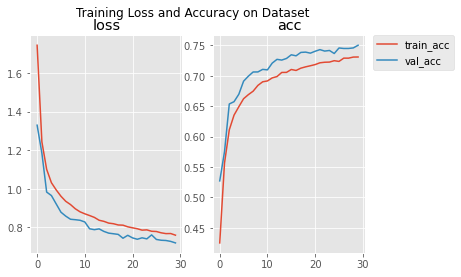

In [6]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Training Loss and Accuracy on Dataset")
ax1.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss"); ax1.set_title('loss');
ax1.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss"); 
ax2.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc"); ax2.set_title('acc');
ax2.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc"); 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Test the trained VGG16 network on the test data

In [7]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),  ## classification_report() outputs the precision etc for each class
	predictions.argmax(axis=1), target_names=labelNames))


[INFO] evaluating network...
              precision    recall  f1-score   support

    airplane       0.82      0.71      0.77      1000
  automobile       0.90      0.81      0.85      1000
        bird       0.75      0.55      0.64      1000
         cat       0.59      0.54      0.56      1000
        deer       0.63      0.79      0.70      1000
         dog       0.68      0.64      0.66      1000
        frog       0.73      0.89      0.80      1000
       horse       0.84      0.78      0.81      1000
        ship       0.81      0.90      0.86      1000
       truck       0.78      0.89      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



The **[f1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)** gives you the **harmonic mean of precision and recall**. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.

The **[support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)** is the **number of samples of the true response** that lie in **that class**.

### Comparison: Try the Pre-Trained VGG16 Model from Keras

Rather than define our own mini-VGGNet model and train it from scratch, we can leverage the pre-trained VGG-16 model and compare its performance.


In [12]:
from tensorflow.keras.applications import VGG19
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input, decode_predictions
import cv2  # OpenCV. Useful for loading/manipulating/saving images
import numpy as np

print('Shape of original test data:', testX.shape)
# Load the built-in pre-trained VGG16 model and apply it to the test set
#pretrained_model = VGG16(weights='imagenet', include_top=True)
pretrained_model = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=trainY.shape[1])

Shape of original test data: (10000, 32, 32, 3)
80150528/80134624 [==============================] - 2s 0us/step


In [13]:
# Need to resize the test images from 32x32 to 244x244 to work with the pre-trained VGG16 network
def resize_data(data):
    data_upscaled = np.zeros((data.shape[0], 244, 244, 3))
    for i, img in enumerate(data):
        large_img = cv2.resize(img, dsize=(244, 244), interpolation=cv2.INTER_CUBIC)
        data_upscaled[i] = large_img

    return data_upscaled

# resize test data
print('Resizing images...')
x_test_resized = resize_data(testX)
print('Shape of resized test data:', x_test_resized.shape) 

Resizing images...
Shape of resized test data: (10000, 244, 244, 3)


In [14]:
# evaluate the network
## Getting an error; giving up. If anyone can solve this, please email me and I'll update the example!
print("[INFO] evaluating network...")
predictions = pretrained_model.predict(x_test_resized, batch_size=32)
decode_predictions(predictions)
print(classification_report(testY.argmax(axis=1), 
                            predictions.argmax(axis=1), 
                            target_names=labelNames), 
      labels=labelNames)

[INFO] evaluating network...


ValueError: in user code:

    /usr/local/lib/python3.9/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /usr/local/lib/python3.9/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /usr/local/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer vgg19: expected shape=(None, 32, 32, 3), found shape=(None, 244, 244, 3)


# Part II: Building an LSTM for Stock Market Prediction

**Long short-term memory (LSTM)** is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTMs have feedback connections.

A common architecture is composed of a **cell** (the memory part of the LSTM unit) and three **"regulators", usually called gates**, of the flow of information inside the LSTM unit: an **input gate**, an **output gate** and a **forget gate**. 

LSTM units can be **trained in a supervised fashion**, on a set of training sequences, using an optimization algorithm, like **gradient descent**, combined with **backpropagation through time** to compute the gradients needed during the optimization process, in order to change each weight of the LSTM network in proportion to the derivative of the error (at the output layer of the LSTM network) with respect to corresponding weight.

**Vanishing Gradients Problem:** A problem with using gradient descent for standard RNNs is that error gradients vanish exponentially quickly with the size of the time lag between important events.

In [15]:
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings("ignore")

# Function to plot the predictions of non-overlapping windows.
# Start with a full window of test data, then predict until window_len 
# predictions have been made. Then start over with a new window of test data.
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()


# Function to load the data from CSV file, then generate overlapping windows of 
# data. Each window is normalized WRT to the first point in the window
def load_data(URL, seq_len, normalise_window):
    pd_data = pd.read_csv(URL)
    data = pd_data.values

    # Split up the data into a bunch of overlapping sequence windows
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

# Function to normalize a window of data by the first point
# First point becomes 0, then subsequent points are % difference from initial
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data


# Function to predict 50 steps into the future, then reload model with new
# window of data. Repeat...
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

## Download the Historical Stock Data

In [16]:
#Step 1 Load Data
URL = 'https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/raw/master/sp500.csv'
X_train, y_train, X_test, y_test = load_data(URL, 50, True)

## Define and Build the LSTM Model

In [17]:
#Step 2 Build Model
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print(f'compilation time : {time.time() - start}') 

compilation time : 0.01408529281616211


In [18]:
# Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=50,
    validation_split=0.05)

Epoch 1/50
7/7 [==============================] - 10s 583ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 2/50
7/7 [==============================] - 4s 519ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 3/50
7/7 [==============================] - 4s 606ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 4/50
7/7 [==============================] - 4s 498ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 5/50
7/7 [==============================] - 4s 577ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 6/50
7/7 [==============================] - 4s 525ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/50
7/7 [==============================] - 4s 511ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 8/50
7/7 [==============================] - 4s 528ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 9/50
7/7 [==============================] - 4s 522ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 10/50
7/7 [==============================] - 4s 574ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 11/50
7/7 [=

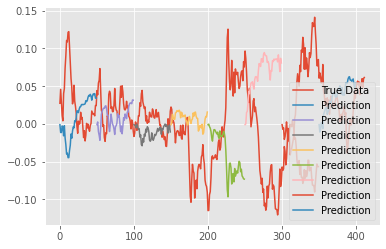

In [19]:
# Step 4 - Plot the predictions!

predictions = predict_sequences_multiple(model, X_test, 50, 50)
plot_results_multiple(predictions, y_test, 50)

# Takeaway Messages

* Keras is the **high-level API of TensorFlow 2.0**, meant to be an approchable and highly-productive interface for solving machine learning problems, with a focus on modern deep learning.
* Convolutional neural networks (CNN) are a class of deep neural networks, **most commonly applied to analyzing visual imagery**. 
* CNNs are **shift invariant** or **space invariant artificial neural networks**, based on their shared-weights architecture and translation invariance characteristics.
* A **benchmark dataset** is a reference database against which learning models are evaluated and performance assessed to determine whether or not a given approach is superior over another.
* The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
* The **[f1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)** gives you the **harmonic mean of precision and recall**. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.
* The **[support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)** is the **number of samples of the true response** that lie in **that class**.
* **Long short-term memory (LSTM)** is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. 
* Unlike standard feedforward neural networks, LSTMs have feedback connections.
* A common architecture is composed of a **cell** (the memory part of the LSTM unit) and three **"regulators", usually called gates**, of the flow of information inside the LSTM unit: an **input gate**, an **output gate** and a **forget gate**. 
* **Vanishing Gradients Problem:** A problem with using gradient descent for standard RNNs is that error gradients vanish exponentially quickly with the size of the time lag between important events.
